### Business Problem
Pune is a city in India. Pune Metro is a metro rail based rapid transit system under construction to serve Pune Central and the areas of Pimpri & Chinchwad. The system comprises 3 lines with a total length of 54.58 km. 
The company KKK Ltd. Is a utility store chain and plans to set up stores near to metro stations. It wants to take advantage of the increase in footfall near to metro station location. In order to decide on the suitable locations, the company wants a preliminary investigation about the venues around the to-be metro stations. The initial investigation is limited to metro stations along the Line 1. The  decision will be forwarded to marketing department for decision on further studies for final decision of product mix to be sold through the metro station outlets.



In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


### Data 

The  official  website of  Pune Metro is   http://punemetrorail.org/ . The name of the metro stations  will be sourced from the website. 
Thereafter , we will load a flat file with the location co-ordinates of the metro stations.
We will leverage on Foursquare Location data.


In [2]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

## let us get the to be Pune Metro Line 1 station list

In [3]:
 !pip install BeautifulSoup4

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
web_url = requests.get('http://punemetrorail.org/').text
soup=BeautifulSoup(web_url,features="html5lib")
#soup.prettify()

In [5]:
table = soup.find('div', class_='tab-content-wrap')
table_rows = table.find_all('li')

df= pd.DataFrame(table_rows)
df1=df.drop(df.columns[[0]], axis = 1) 
df1.rename(columns={ df.columns[1]: "Station" }, inplace = True)
df1['Station'] = df1.Station.str.replace('\t', '')
df1.head()

,Station
0,PCMC
1,Sant Tukaram Nagar
2,Bhosari (Nashik Phata)
3,Kasarwadi
4,Phugewadi


In [6]:
## Let us load  the Latitude and longitudes of only Line 1 stations.
latlon = pd.read_csv("Line1Metrostations.csv")
latlon.head()

,Station,latitude,longitude
0,PCMC,18.598609,73.797170
1,Sant Tukaram Nagar,18.622561,73.820851
2,Bhosari(Nashik Phata),18.611349,73.823623
3,Kasarwadi,18.606410,73.821294
4,Phugewadi,18.590464,73.831599


### Create a map of Pune with neighborhoods superimposed on top.

In [7]:
# create map of New York using latitude and longitude values
map_pune = folium.Map(location=[18.5204, 73.8567], zoom_start=10)

# add markers to map
for lat, lng, Station in zip(latlon['latitude'], latlon['longitude'], latlon['Station']):
    label = '{}'.format(Station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pune)  
    
map_pune

In [8]:
station_latitude = latlon.loc[0, 'latitude'] # Station neighborhood latitude value
station_longitude = latlon.loc[0, 'longitude'] # Station neighborhood longitude value

station_name = latlon.loc[0, 'Station'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(station_name, 
                                                               station_latitude, 
                                                               station_longitude))

Latitude and longitude values of PCMC are 18.598609, 73.79717.


### Now, let's get the top 100 venues that are in PCMC within a radius of 1500 meters

In [9]:
# type your answer here

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    20180605, 
    station_latitude, 
    station_longitude, 
    1500, 
    100)
#url # display URL


In [10]:
results = requests.get(url).json()
#results

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Cafe Coffee Day,Café,18.593421,73.795461
1,Subway,Sandwich Place,18.596270,73.789194
2,18 Degrees,Lounge,18.593509,73.785879
3,Pizza Hut,Pizza Place,18.593176,73.798399
4,Naturals Icecream,Ice Cream Shop,18.595114,73.803898


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

22 venues were returned by Foursquare.


### Explore Neighborhoods in Pune
Let's create a function to repeat the same process to all the neighborhoods in Pune

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now write the code to run the above function on each neighborhood and create a new dataframe called pune_venues

In [15]:
pune_venues = getNearbyVenues(names=latlon['Station'],
                                   latitudes=latlon['latitude'],
                                   longitudes=latlon['longitude']
                                  )


PCMC
Sant Tukaram Nagar
Bhosari(Nashik Phata)
Kasarwadi
Phugewadi
Dapodi
Bopodi
Khadki
Range Hill
Shivajinagar
Civil Court
Budhwar peth
Mandai
Swargate


In [16]:
print(pune_venues.shape)
pune_venues.head()

(521, 7)


,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PCMC,18.598609,73.79717,Cafe Coffee Day,18.593421,73.795461,Café
1,PCMC,18.598609,73.79717,Subway,18.596270,73.789194,Sandwich Place
2,PCMC,18.598609,73.79717,18 Degrees,18.593509,73.785879,Lounge
3,PCMC,18.598609,73.79717,Pizza Hut,18.593176,73.798399,Pizza Place
4,PCMC,18.598609,73.79717,Naturals Icecream,18.595114,73.803898,Ice Cream Shop


In [17]:
#venues by metro statons
pune_venues.groupby('Station').count()


,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station,,,,,,
Bhosari(Nashik Phata),19,19,19,19,19,19
Bopodi,20,20,20,20,20,20
Budhwar peth,53,53,53,53,53,53
Civil Court,77,77,77,77,77,77
Dapodi,21,21,21,21,21,21
Kasarwadi,16,16,16,16,16,16
Khadki,5,5,5,5,5,5
Mandai,61,61,61,61,61,61
PCMC,22,22,22,22,22,22


In [18]:
pune_venue_cat=pune_venues[['Station','Venue Category']]
pune_venue_cat

,Station,Venue Category
0,PCMC,Café
1,PCMC,Sandwich Place
2,PCMC,Lounge
3,PCMC,Pizza Place
4,PCMC,Ice Cream Shop
...,...,...
516,Swargate,Indian Restaurant
517,Swargate,Coffee Shop
518,Swargate,Restaurant
519,Swargate,Furniture / Home Store


In [19]:
pune_venue_count=pune_venue_cat.groupby('Station').count()
pune_venue_count

,Venue Category
Station,
Bhosari(Nashik Phata),19
Bopodi,20
Budhwar peth,53
Civil Court,77
Dapodi,21
Kasarwadi,16
Khadki,5
Mandai,61
PCMC,22


In [20]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(pune_venues['Venue Category'].unique())))

There are 91 uniques categories.


In [21]:
pune_venues['Venue Category'].unique()


array(['Café', 'Sandwich Place', 'Lounge', 'Pizza Place',
       'Ice Cream Shop', 'Chinese Restaurant', 'American Restaurant',
       'Shopping Mall', 'Fast Food Restaurant', 'North Indian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Indian Restaurant',
       'Convenience Store', 'Gym', 'Snack Place', 'Wine Shop',
       'Food Truck', 'Cosmetics Shop', 'Bus Station', 'Hotel',
       'Dessert Shop', 'Gas Station', 'Hotel Bar',
       'Indian Chinese Restaurant', 'Italian Restaurant', 'Gift Shop',
       'Platform', 'Restaurant', 'Coffee Shop', 'Department Store',
       'Train Station', 'Thai Restaurant', 'Food Court', 'Cafeteria',
       'Breakfast Spot', 'Tea Room', 'Bakery', 'Bank', 'Diner',
       'Vietnamese Restaurant', 'Multiplex', 'Asian Restaurant',
       'Bookstore', 'Nightclub', 'Theme Park', 'Deli / Bodega', 'Bistro',
       'Fried Chicken Joint', 'Pub', 'Maharashtrian Restaurant',
       'Juice Bar', 'Stadium', 'South Indian Restaurant', 'Donut Shop',
       'Bu

In [22]:
pune_venue_count.dtypes

Venue Category    int64
dtype: object

Text(0, 0.5, 'No of Unique categories')

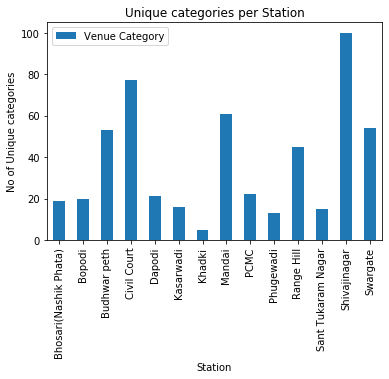

In [23]:

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

pune_venue_count.plot(kind="bar")

plt.title("Unique categories per Station")
plt.xlabel("Station")
plt.ylabel("No of Unique categories")

In [24]:
pune_venue_transform=pune_venues[['Venue Category','Station']]
pune_venue_transform

,Venue Category,Station
0,Café,PCMC
1,Sandwich Place,PCMC
2,Lounge,PCMC
3,Pizza Place,PCMC
4,Ice Cream Shop,PCMC
...,...,...
516,Indian Restaurant,Swargate
517,Coffee Shop,Swargate
518,Restaurant,Swargate
519,Furniture / Home Store,Swargate


In [25]:
pune_loc_count=pune_venue_cat.groupby('Venue Category').count()
sort_by_venuecat = pune_loc_count.sort_values('Station',ascending=True)
sort_by_venuecat

,Station
Venue Category,
American Restaurant,1
Fried Chicken Joint,1
Frozen Yogurt Shop,1
Fruit & Vegetable Store,1
Furniture / Home Store,1
...,...
Ice Cream Shop,18
Snack Place,23
Coffee Shop,23


In [27]:
#Find the Venue categories that are not common across stations
Unique_cat=sort_by_venuecat.loc[sort_by_venuecat['Station'] == 1]
Unique_cat

,Station
Venue Category,
American Restaurant,1
Fried Chicken Joint,1
Frozen Yogurt Shop,1
Fruit & Vegetable Store,1
Furniture / Home Store,1
Gastropub,1
Gift Shop,1
Hookah Bar,1
Wine Shop,1


In [28]:
# Let us see which ocations have some f those unique categories that occur once
options = ['American Restaurant','Furniture / Home Store','Gastropub','IT Services','Middle Eastern Restaurant','Nightlife','Vietnamese Restaurant']

rslt_df = pune_venues[pune_venues['Venue Category'].isin(options)]
rslt_df

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8,PCMC,18.598609,73.797170,KFC Restaurant,18.593440,73.786083,American Restaurant
124,Bopodi,18.570910,73.836426,Smiley House,18.562297,73.829573,Vietnamese Restaurant
338,Civil Court,18.527608,73.855151,LTI,18.534989,73.851935,IT Services
347,Civil Court,18.527608,73.855151,Marrakesh,18.524349,73.841362,Middle Eastern Restaurant
480,Swargate,18.499020,73.859070,Aufside,18.501410,73.872157,Gastropub
519,Swargate,18.499020,73.859070,Timber Market,18.509267,73.868149,Furniture / Home Store


### let us analyse all the Pune metro neighborhoods

In [29]:
# one hot encoding
pune_onehot = pd.get_dummies(pune_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pune_onehot['Station'] = pune_venues['Station'] 

# move neighborhood column to the first column
fixed_columns = [pune_onehot.columns[-1]] + list(pune_onehot.columns[:-1])
pune_onehot = pune_onehot[fixed_columns]

pune_onehot.head()

,Station,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bed & Breakfast,Bistro,...,Tennis Court,Thai Restaurant,Theater,Theme Park,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store
0,PCMC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PCMC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PCMC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PCMC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PCMC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# dataframe size
pune_onehot.shape

(521, 92)

In [31]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

pune_grouped = pune_onehot.groupby('Station').mean().reset_index()
pune_grouped

,Station,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bed & Breakfast,Bistro,...,Tennis Court,Thai Restaurant,Theater,Theme Park,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store
0,Bhosari(Nashik Phata),0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Bopodi,0.000000,0.000000,0.000000,0.000000,0.100000,0.05,0.000000,0.000000,0.000000,...,0.000000,0.050000,0.000000,0.000000,0.000000,0.100000,0.000000,0.05,0.000000,0.000000
2,Budhwar peth,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.018868,0.000000,...,0.018868,0.000000,0.018868,0.000000,0.000000,0.000000,0.075472,0.00,0.000000,0.000000
3,Civil Court,0.000000,0.000000,0.012987,0.012987,0.025974,0.00,0.038961,0.000000,0.000000,...,0.000000,0.000000,0.012987,0.000000,0.000000,0.000000,0.012987,0.00,0.000000,0.000000
4,Dapodi,0.000000,0.000000,0.000000,0.000000,0.047619,0.00,0.000000,0.000000,0.000000,...,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.000000,0.00,0.000000,0.000000
5,Kasarwadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Khadki,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.000000,0.000000
7,Mandai,0.000000,0.016393,0.000000,0.000000,0.016393,0.00,0.016393,0.000000,0.000000,...,0.016393,0.000000,0.016393,0.000000,0.000000,0.000000,0.049180,0.00,0.000000,0.016393
8,PCMC,0.045455,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.00,0.045455,0.000000
9,Phugewadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.00,0.000000,0.000000


In [32]:
#new Size
pune_grouped.shape

(14, 92)

###### Top five common venues 

In [33]:
num_top_venues = 5

for hood in pune_grouped['Station']:
    print("----"+hood+"----")
    temp = pune_grouped[pune_grouped['Station'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bhosari(Nashik Phata)----
                venue  freq
0   Indian Restaurant  0.37
1         Bus Station  0.11
2           Hotel Bar  0.05
3               Hotel  0.05
4  Italian Restaurant  0.05


----Bopodi----
                venue  freq
0   Indian Restaurant  0.15
1              Bakery  0.10
2       Train Station  0.10
3  Chinese Restaurant  0.10
4     Thai Restaurant  0.05


----Budhwar peth----
                           venue  freq
0              Indian Restaurant  0.23
1                    Snack Place  0.09
2  Vegetarian / Vegan Restaurant  0.08
3             Seafood Restaurant  0.06
4                 Ice Cream Shop  0.06


----Civil Court----
                venue  freq
0   Indian Restaurant  0.21
1      Sandwich Place  0.05
2      Ice Cream Shop  0.05
3                Café  0.04
4  Seafood Restaurant  0.04


----Dapodi----
                  venue  freq
0     Indian Restaurant  0.10
1           Snack Place  0.10
2       Thai Restaurant  0.05
3            Food Court  0.05
4  

#Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
station_venues_sorted = pd.DataFrame(columns=columns)
station_venues_sorted['Station'] = pune_grouped['Station']

for ind in np.arange(pune_grouped.shape[0]):
    station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pune_grouped.iloc[ind, :], num_top_venues)

station_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bhosari(Nashik Phata),Indian Restaurant,Bus Station,Gift Shop,Snack Place,Fast Food Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hotel Bar,Hotel,Gas Station
1,Bopodi,Indian Restaurant,Chinese Restaurant,Train Station,Bakery,Hotel,Italian Restaurant,Cafeteria,Food Court,Breakfast Spot,Diner
2,Budhwar peth,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Ice Cream Shop,Seafood Restaurant,Fast Food Restaurant,Convenience Store,Dessert Shop,Tea Room,Café
3,Civil Court,Indian Restaurant,Sandwich Place,Ice Cream Shop,Seafood Restaurant,Hotel,Bar,Café,Fast Food Restaurant,Bakery,Historic Site
4,Dapodi,Snack Place,Indian Restaurant,Ice Cream Shop,Department Store,Fast Food Restaurant,Food Court,Coffee Shop,Restaurant,Chinese Restaurant,Cafeteria


### Cluster venues for all metro station neighbourhoods

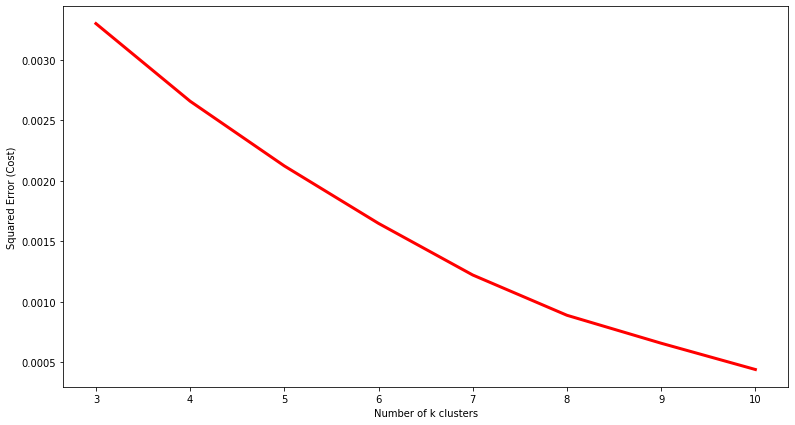

In [36]:
#finding the optimal number of k
pune_grouped_clustering = pune_grouped.drop('Station', 1)
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(pune_grouped_clustering)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

In [37]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pune_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 0, 0, 2, 3, 1, 0, 4, 6])

In [38]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
station_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

pune_merged = latlon

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
pune_merged = pune_merged.join(station_venues_sorted.set_index('Station'), on='Station')

pune_merged.head() # check the last columns!

,Station,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PCMC,18.598609,73.797170,4,Fast Food Restaurant,Pizza Place,Indian Restaurant,Chinese Restaurant,Sandwich Place,Snack Place,Gym,Wine Shop,Ice Cream Shop,Lounge
1,Sant Tukaram Nagar,18.622561,73.820851,5,Bus Station,Indian Restaurant,Sandwich Place,Chinese Restaurant,Café,Snack Place,Food Truck,Dessert Shop,Cosmetics Shop,Gas Station
2,Bhosari(Nashik Phata),18.611349,73.823623,3,Indian Restaurant,Bus Station,Gift Shop,Snack Place,Fast Food Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hotel Bar,Hotel,Gas Station
3,Kasarwadi,18.606410,73.821294,3,Indian Restaurant,Fast Food Restaurant,Bus Station,Platform,Cosmetics Shop,Gas Station,Hotel Bar,Indian Chinese Restaurant,Italian Restaurant,Snack Place
4,Phugewadi,18.590464,73.831599,6,Indian Restaurant,Fast Food Restaurant,Food Truck,Dessert Shop,Restaurant,Coffee Shop,Snack Place,Department Store,Hotel,Train Station


In [39]:
#Let us visualize the clusters for Pune

import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[18.5204, 73.8567], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pune_merged['latitude'], pune_merged['longitude'], pune_merged['Station'], pune_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the Clusters

In [40]:
pune_merged.loc[pune_merged['Cluster Labels'] == 0, pune_merged.columns[[0] + list(range(4, pune_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Range Hill,Lounge,Indian Restaurant,Coffee Shop,Chinese Restaurant,Café,Asian Restaurant,Italian Restaurant,Gym,Hotel,Multiplex
9,Shivajinagar,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Café,Sandwich Place,Multiplex,Chinese Restaurant,Restaurant,Ice Cream Shop,Dessert Shop
10,Civil Court,Indian Restaurant,Sandwich Place,Ice Cream Shop,Seafood Restaurant,Hotel,Bar,Café,Fast Food Restaurant,Bakery,Historic Site
11,Budhwar peth,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Ice Cream Shop,Seafood Restaurant,Fast Food Restaurant,Convenience Store,Dessert Shop,Tea Room,Café
12,Mandai,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Ice Cream Shop,Jewelry Store,Dessert Shop,Coffee Shop,Seafood Restaurant,Convenience Store,Men's Store
13,Swargate,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Men's Store,Southern / Soul Food Restaurant,Multiplex,Shopping Mall,Snack Place,Mobile Phone Shop


In [41]:
pune_merged.loc[pune_merged['Cluster Labels'] == 1, pune_merged.columns[[0] + list(range(4, pune_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Khadki,Department Store,Train Station,Bakery,Food Truck,Fried Chicken Joint,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store


In [42]:
pune_merged.loc[pune_merged['Cluster Labels'] == 2, pune_merged.columns[[0] + list(range(4, pune_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Dapodi,Snack Place,Indian Restaurant,Ice Cream Shop,Department Store,Fast Food Restaurant,Food Court,Coffee Shop,Restaurant,Chinese Restaurant,Cafeteria
6,Bopodi,Indian Restaurant,Chinese Restaurant,Train Station,Bakery,Hotel,Italian Restaurant,Cafeteria,Food Court,Breakfast Spot,Diner


In [43]:
pune_merged.loc[pune_merged['Cluster Labels'] == 3, pune_merged.columns[[0] + list(range(5, pune_merged.shape[1]))]]

,Station,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bhosari(Nashik Phata),Bus Station,Gift Shop,Snack Place,Fast Food Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hotel Bar,Hotel,Gas Station
3,Kasarwadi,Fast Food Restaurant,Bus Station,Platform,Cosmetics Shop,Gas Station,Hotel Bar,Indian Chinese Restaurant,Italian Restaurant,Snack Place


In [44]:
pune_merged.loc[pune_merged['Cluster Labels'] == 4, pune_merged.columns[[0] + list(range(4, pune_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PCMC,Fast Food Restaurant,Pizza Place,Indian Restaurant,Chinese Restaurant,Sandwich Place,Snack Place,Gym,Wine Shop,Ice Cream Shop,Lounge


In [45]:
pune_merged.loc[pune_merged['Cluster Labels'] == 5, pune_merged.columns[[0] + list(range(4, pune_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Sant Tukaram Nagar,Bus Station,Indian Restaurant,Sandwich Place,Chinese Restaurant,Café,Snack Place,Food Truck,Dessert Shop,Cosmetics Shop,Gas Station


In [46]:
pune_merged.loc[pune_merged['Cluster Labels'] == 6, pune_merged.columns[[0] + list(range(4, pune_merged.shape[1]))]]

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Phugewadi,Indian Restaurant,Fast Food Restaurant,Food Truck,Dessert Shop,Restaurant,Coffee Shop,Snack Place,Department Store,Hotel,Train Station
